In [42]:
%matplotlib inline

### EL2114 Circuitos en Corriente Alterna 2024 S2

(C) 2021-2024 Pablo Alvarado <br>
Escuela de Ingeniería Electrónica<br>
Tecnológico de Costa Rica<br>

Jupyter Notebook para analizar distribución de puntajes en exámenes.
Para funcionar requiere suficientes datos (>100) y por tanto se usa
para exámenes aplicados a varios grupos (p.ej. CA y SyS).

Con pocos datos el script requiere ayuda manual en selección de los 
parámetros más relevantes:
- selección del ancho de banda para la estimación de la densidad probabilística
- número de gaussianas en GMM


## Estadísticas del primer parcial

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.mixture import GaussianMixture

import time
import mgmm as m

from IPython import display

Configuración:

In [44]:
archivo_csv = 'parcial_all.csv' ## Recordar que las columnas tienen que estar separadas por ';'

col_pts = 1    ## Columna en el CSV con los puntos a analizar
col_grupos = 0 ## Columna en el CSV con el número de grupo

total_pts = 34 ## Máximo puntaje obtenible en la columna col_pts
min_accepted_pts = 5 ## Puntaje mínimo aceptado

detailed_stats = False ## Haga estimaciones para varios BW para ver variación de umbrales

horizontal=12  ## Tamaño de las figuras
figsize=(horizontal,horizontal/(16/9))

Cargar todos los datos en archivo csv

In [45]:
rawdata = np.genfromtxt(archivo_csv, delimiter=';')
print("Datos completos en matriz {0} x {1}".format(rawdata.shape[0],rawdata.shape[1]))

data=rawdata[rawdata[:,col_pts]>=min_accepted_pts]
print("Datos aceptados en matriz {0} x {1}".format(data.shape[0],data.shape[1]))

# La columna col_pts tiene los puntos totales obtenidos por cada estudiante
pts=data[:,col_pts].reshape(-1,1)
print(pts.shape)

# La columna col_grupos tiene los grupos
grs=data[:,col_grupos].reshape(-1,1)
grs=np.where(grs==20,3,grs) # Reemplace Gr.20->3
grs=np.where(grs==50,4,grs) # Reemplace Gr.50->4

Datos completos en matriz 85 x 2
Datos aceptados en matriz 81 x 2
(81, 1)


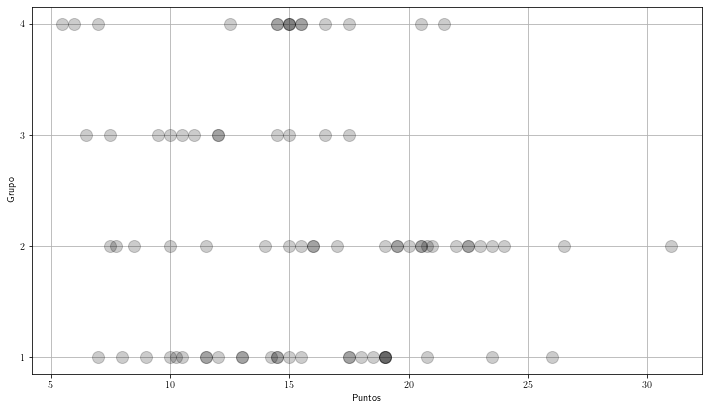

In [46]:
# Ver datos de forma simple por grupo.
# Usamos un color transparente, de modo que si se sobreponen puntos se
# verá más oscuro

plt.figure(figsize=figsize)
plt.plot(pts,grs,'o',alpha=0.2,color="Black",markersize=12)
plt.xlabel("Puntos")
plt.ylabel("Grupo")
plt.yticks(np.unique(grs))
plt.grid(True)

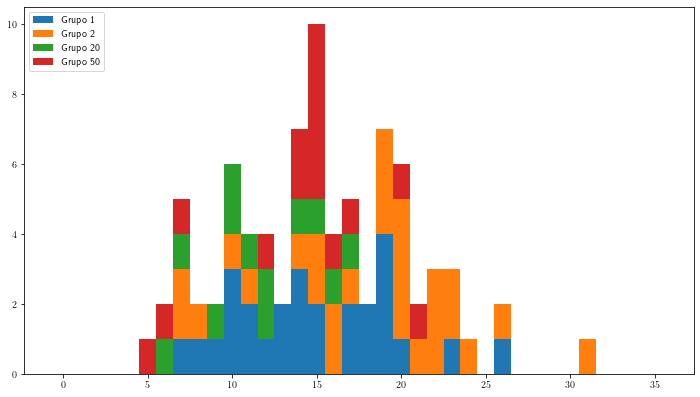

In [47]:
# Creemos un histograma pero visualizando cada grupo
grppts=[data[data[:,col_grupos]==k,col_pts] for k in np.unique(data[:,col_grupos])]
grplabels=["Grupo {0}".format(int(k)) for k in np.unique(data[:,col_grupos])]

plt.figure(figsize=figsize)
plt.hist(grppts,
         bins=total_pts+1,
         range=(0,total_pts+1),
         align='left',
         density=False,
         histtype='barstacked',
         label=grplabels)
plt.legend(loc='upper left')

## Selección del ancho de banda

La validación cruzada no es tan estable como se desearía, entonces vamos a repetir la estimación varias veces para extraer el valor esperado del ancho de banda en varios experimentos.

Como dicha estimación produce una distribución multimodal, entonces tenemos que aplicar lo mismo recursivamente para encontrar el ancho de banda que permite estimar las modas en la distribución de anchos de banda, con las que se seleccionará el ancho de banda a utilizar.

Esto puede tardar unos minutos.

In [48]:
np.random.seed(2) ## Intentando que siempre se den los mismos resultados

# Corra muchos experimentos para extraer candidatos a bandwidth.
# Esto toma tiempo, así que se guardarán en un archivo los datos para no
# regenerarlos cada vez que se corra este script.

bw,toc = m.bandwidth(pts,
                     bw_range=np.logspace(np.log10(1),np.log10(10),1000,base=10.0),
                     cv_range=np.arange(8,13),
                     cv_rep=200, 
                     n_iter=25,
                     load_file='bw_pts.pik')

print("\n\nTardó {0}".format(time.strftime('%Hh %Mm %Ss',time.gmtime(toc))))


bw_median = np.median(bw)
bw_mean = np.mean(bw)

print("\nBandwidth median:",bw_median)
print("Bandwidth mean:",bw_mean)

File 'bw_pts.pik': [Errno 2] No such file or directory: 'bw_pts.pik'
Exp 1000/1000:  cv=12  bandwidth: 2.8474391664672463             
Saving file 'bw_pts.pik'


Tardó 00h 02m 23s

Bandwidth median: 2.675638444552045
Bandwidth mean: 2.6923713076900935


Text(0, 0.5, 'Bandwidth')

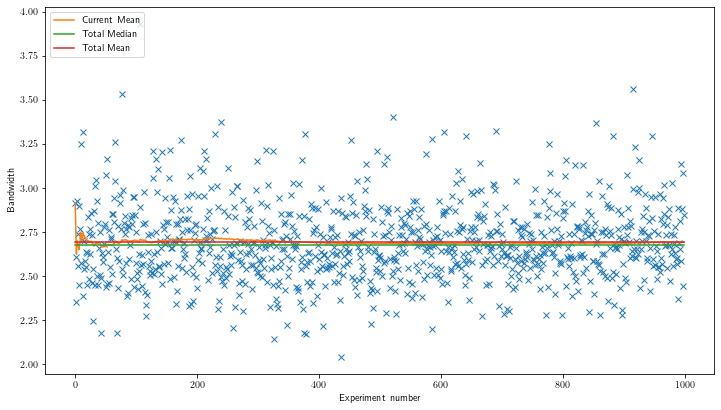

In [49]:
plt.figure(figsize=figsize)
plt.plot(list(np.arange(len(bw))),bw,'x')
plt.plot(list(np.arange(len(bw))),np.cumsum(bw)/np.arange(1,len(bw)+1),label="Current Mean")

plt.plot([0,len(bw)-1],[bw_median,bw_median],label="Total Median")
plt.plot([0,len(bw)-1],[bw_mean,bw_mean],label="Total Mean")
plt.legend(loc='upper left')
plt.xlabel("Experiment number")
plt.ylabel("Bandwidth")

In [50]:
# Dejavù

# Usemos estimación de kernel para esa distribución de anchos de banda
bwe,toc = m.bandwidth(np.array(bw).copy().reshape(-1,1),
                      bw_range=np.logspace(np.log10(0.01),np.log10(4),1000,base=10.0),
                      cv_range=np.arange(10,11),
                      cv_rep=1000,
                      n_iter=25,
                      load_file='bw_bw.pik')

print("\n\nTardó {0}".format(time.strftime('%Hh %Mm %Ss',time.gmtime(toc))))


bwe_median = np.median(bwe)
bwe_mean = np.mean(bwe)

print("\nBandwidth median:",bwe_median)
print("Bandwidth mean:",bwe_mean)

File 'bw_bw.pik': [Errno 2] No such file or directory: 'bw_bw.pik'
Exp 1000/1000:  cv=10  bandwidth: 0.07592357574720271             
Saving file 'bw_bw.pik'


Tardó 00h 03m 31s

Bandwidth median: 0.08307046156822395
Bandwidth mean: 0.08347351677917599


Text(0, 0.5, 'Bandwidth')

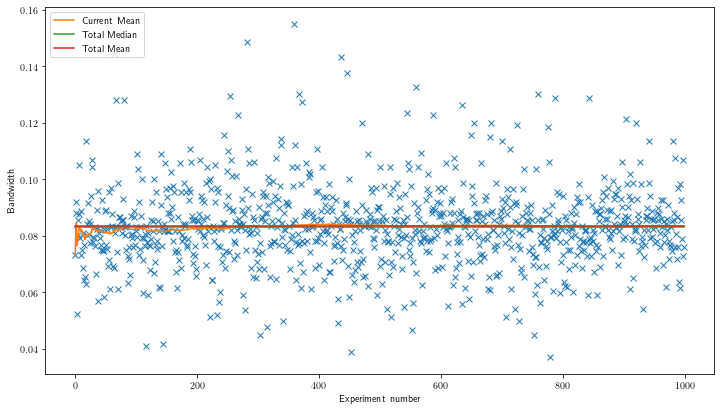

In [51]:
plt.figure(figsize=figsize)
plt.plot(list(np.arange(len(bwe))),bwe,'x')
plt.plot(list(np.arange(len(bwe))),np.cumsum(bwe)/np.arange(1,len(bwe)+1),label="Current Mean")

plt.plot([0,len(bwe)-1],[bwe_median,bwe_median],label="Total Median")
plt.plot([0,len(bwe)-1],[bwe_mean,bwe_mean],label="Total Mean")
plt.legend(loc='upper left')
plt.xlabel("Experiment number")
plt.ylabel("Bandwidth")

Estimando el bandwidth para estimar el bandwidth:
  bic con 1 componentes = -5680.8613392665075
  bic con 2 componentes = -5796.850070995792
  bic con 3 componentes = -5785.165140026934
  bic con 4 componentes = -5769.75894121967
  bic con 5 componentes = -5752.129823712274
  bic con 6 componentes = -5738.0095624123505
  bic con 7 componentes = -5723.724104686448
  bic con 8 componentes = -5708.4714527092765
  bic con 9 componentes = -5685.551597183183
  bic con 10 componentes = -5667.319465349487
Best components: 2
Mejor bandwidth para estimar el bandwidth: 0.08205320410949815


Text(0, 0.5, 'Veces seleccionado')

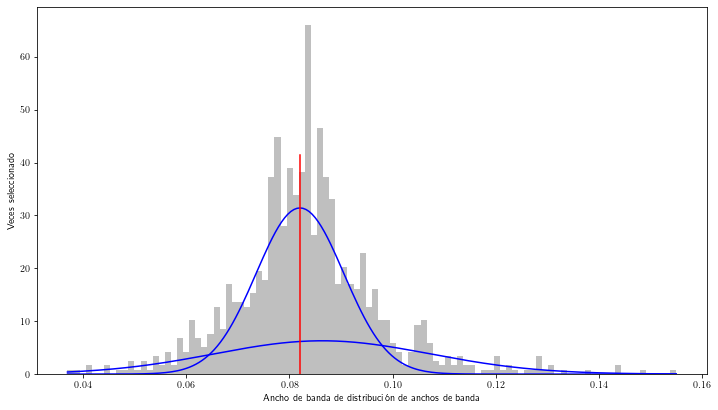

In [52]:
# Backtracking
print("Estimando el bandwidth para estimar el bandwidth:")
bwegmm=m.fitGMM(np.array(bwe).copy().reshape(-1,1),
               n_components_range=range(1,11))

bwbw,_=m.dominantGaussian(bwegmm)
print("Mejor bandwidth para estimar el bandwidth:",bwbw)

# Show a histogram of the bandwidths
plt.figure(figsize=figsize)
_=plt.hist(bwe,bins=int(len(bwe)*0.1),
           range=(np.min(bwe),np.max(bwe)),
           color="Gray",
           alpha=0.5,
           density=True)

xbw=np.linspace(np.min(bwe),np.max(bwe),200)

# Muestre las gaussianas estimadas
for i in np.arange(bwegmm.n_components):
    plt.plot(xbw,
             bwegmm.weights_[i]*
             norm(bwegmm.means_[i],np.sqrt(bwegmm.covariances_[i])).pdf(xbw),
             color="Blue",alpha=1) 
    
maxval=np.exp(bwegmm.score([[bwbw]]))
plt.plot([bwbw,bwbw],[0,1.1*maxval],color="Red")
plt.xlabel("Ancho de banda de distribución de anchos de banda")
plt.ylabel("Veces seleccionado")



Estimando el bandwidth definitivo:
  bic con 1 componentes = -228.51633983422997
  bic con 2 componentes = -285.13773081606325
  bic con 3 componentes = -258.4311122868598
  bic con 4 componentes = -239.17265126001737
  bic con 5 componentes = -221.5154698812616
  bic con 6 componentes = -199.46248101971523
  bic con 7 componentes = -188.95742193749425
  bic con 8 componentes = -183.6891258898721
  bic con 9 componentes = -162.0721877719609
  bic con 10 componentes = -149.5928620970603
Best components: 2


Mejor bandwidth: 2.633219629975243


Text(0, 0.5, 'Veces seleccionado')

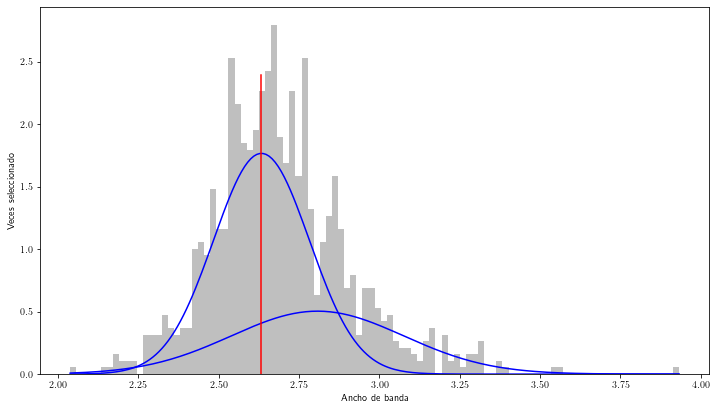

In [53]:
print("\n\nEstimando el bandwidth definitivo:")
bwgmm=m.fitGMM(np.array(bw).copy().reshape(-1,1),
               n_components_range=range(1,11))

bw_,_=m.dominantGaussian(bwgmm)
print("\n\nMejor bandwidth:",bw_)

xbw=np.linspace(np.min(bw),np.max(bw),200)

# Show a histogram of the bandwidths
plt.figure(figsize=figsize)
_=plt.hist(bw,bins=int(len(bw)*0.1),
           range=(np.min(bw),np.max(bw)),
           color="Gray",
           alpha=0.5,
           density=True)

# Muestre las gaussianas estimadas
for i in np.arange(bwgmm.n_components):
    plt.plot(xbw,
             bwgmm.weights_[i]*
             norm(bwgmm.means_[i],np.sqrt(bwgmm.covariances_[i])).pdf(xbw),
             color="Blue",alpha=1)     

maxval=np.exp(bwgmm.score([[bw_]]))
plt.plot([bw_,bw_],[0,1.1*maxval],color="Red")
plt.xlabel("Ancho de banda")
plt.ylabel("Veces seleccionado")

In [54]:
kde = KernelDensity(bandwidth=bw_).fit(pts)

print("Ancho de banda a usar: ",kde.bandwidth)

Ancho de banda a usar:  2.633219629975243


# Distribución de puntos obtenidos

Mostraremos a continuación varios resultados de la densidad de probabilidad estimada con el mejor kernel


Text(0, 0.5, 'p(Puntos)')

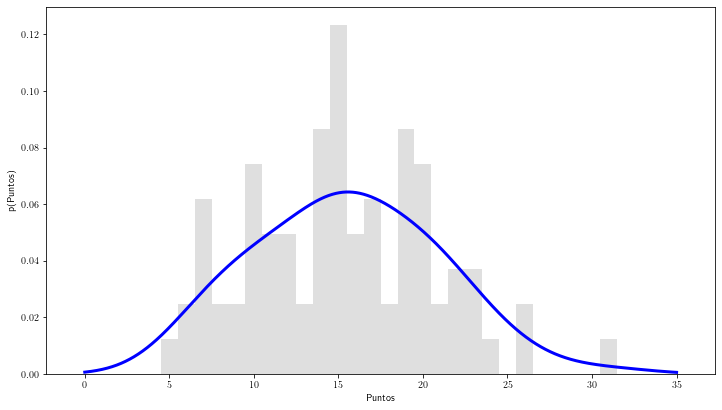

In [55]:
# Muestre el histograma de puntaje, solo para comparación
plt.figure(figsize=figsize)
plt.hist(pts,bins=total_pts+1,range=(0,total_pts+1),align='left',density=True,color="Gray",alpha=0.25)

# Muestre la densidad estimada con el mejor ancho de banda
xplot = np.linspace(0,total_pts,10001)
dens = np.exp(kde.score_samples(xplot[:,np.newaxis]))

plt.plot(xplot,dens,linewidth=3,color="Blue")
plt.xlabel("Puntos")
plt.ylabel("p(Puntos)")

#plt.savefig("kde.pdf")

In [56]:
# El estimador de densidad al usar un gaussiano se va 
# a salir del rango dado.  Esto es el porcentaja del
# área que encaja en el rango de interés.

np.sum(dens)*(total_pts)/xplot.shape[0]

0.9984409234723701

Text(0, 0.5, 'p(Puntos)')

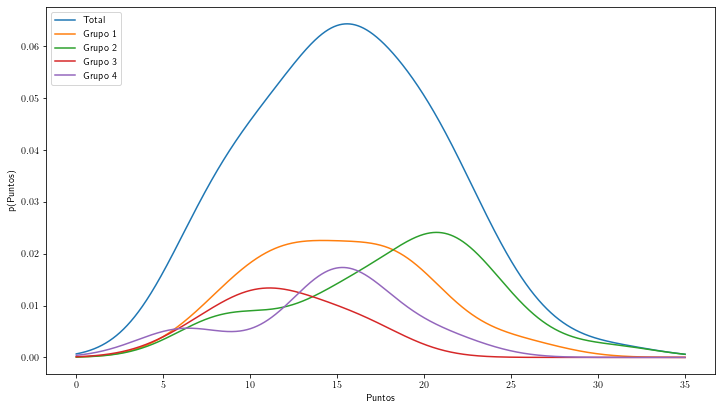

In [57]:
# Muestre ahora la densidad anterior junto a estimaciones hechas para cada 
# grupo por aparte

plt.figure(figsize=figsize)
plt.plot(xplot,dens,label="Total")

for g in np.unique(grs).astype('int'):
    gpts = pts[grs==g].reshape(-1,1)
    gkde = KernelDensity(kernel="gaussian",bandwidth=kde.bandwidth,leaf_size=4).fit(gpts)
    grlp = np.exp(gkde.score_samples(xplot[:,np.newaxis]))
    
    fraction = gpts.shape[0]/pts.shape[0]
    
    plt.plot(xplot,fraction*grlp,label="Grupo {0}".format(g))
    plt.legend(loc='upper left')
    
plt.xlabel("Puntos")
plt.ylabel("p(Puntos)")

# GMM

Si usamos solo los datos originales, como son relativamente pocos, el GMM queda lejos de la densidad estimada con el kernel gaussiano, por lo que mejor muestreamos el proceso con la densisdad estimada y sacamos muchos más datos, y a partir de esos estimamos el GMM

In [58]:
samples = kde.sample(50000) # Usemos MUCHOS datos (muestra aleatoria)

Lo siguiente busca exhaustivamente el número óptimo de gaussianas a utilizar.

Si hay más de dos gaussianas querría decir que hay sub-poblaciones involucradas y no se puede saber exactamente cuales corresponderían a "dominan materia" y cuales a "no dominan materia".  En ese caso puede usarse el modelo con dos gaussianas o pueden seleccionarse con criterio dos modelos de mezcla de gaussianas para cada una de las dos poblaciones.

In [59]:
# Rango de número de gaussianas usar
#   Usualmente será mínimo 2 y máximo 7: range(2,8), pero puede 
#   forzarse a un número específico o solo pares, etc.
#
#   El análisis abajo también usará este rango
n_components_range=np.arange(2, 8, 1) #[2,4,6,8] # np.arange(2, 8, 1)

best_gmm=m.fitGMM(samples,
                 n_components_range=n_components_range)

best_n_components=best_gmm.n_components

print("\n\nMejor número de componentes en GMM: ",best_n_components)

  bic con 2 componentes = 319908.0767073973
  bic con 4 componentes = 319779.3247491935
  bic con 6 componentes = 319793.5545655828
  bic con 8 componentes = 319796.6833275299
Best components: 4


Mejor número de componentes en GMM:  4


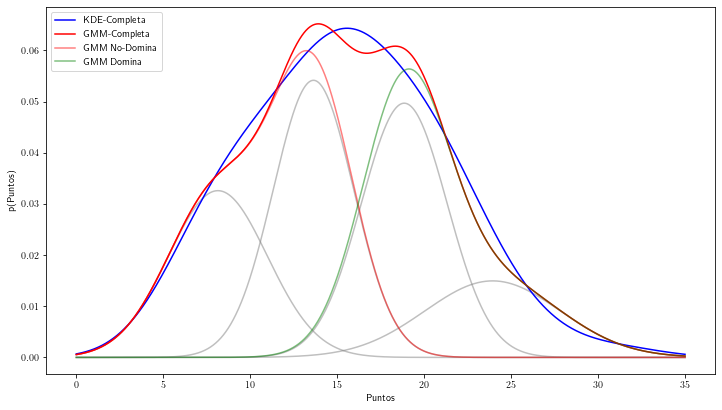

In [60]:
plt.figure(figsize=figsize)

# MANUALMENTE: lo que sigue indica cuántas gaussianas considerar para
#              la clase de las personas que "dominan la materia".  Puede
#              requerir ajuste manual
cuantas_gaussianas_para_domina=int(best_gmm.n_components/2)
mgmm=m.MGMM(best_gmm,cuantas_gaussianas_para_domina)

# Muestre las gaussianas estimadas
for i in np.arange(best_n_components):
    plt.plot(xplot,
             best_gmm.weights_[i]*
             norm(best_gmm.means_[i],np.sqrt(best_gmm.covariances_[i])).pdf(xplot),
             color="Gray",alpha=0.5) 

plt.plot(xplot,dens,'-b',label="KDE-Completa")

best_gmm_dens=np.exp(best_gmm.score_samples(xplot[:,np.newaxis]))    

plt.plot(xplot,best_gmm_dens,'-r',label="GMM-Completa")

plt.plot(xplot,mgmm.likelihood(0,xplot)*mgmm.p_[0],color="Red",alpha=0.5,label="GMM No-Domina")
plt.plot(xplot,mgmm.likelihood(1,xplot)*mgmm.p_[1],color="Green",alpha=0.5,label="GMM Domina")

plt.xlabel("Puntos")
plt.ylabel("p(Puntos)")
plt.legend(loc='upper left')

## Umbral de decisión Bayesiana

Sean las clases domina-materia $D$ y no-domina-materia $\lnot D$, y $\rho$ los puntos obtenidos.  Se debe cumplir entonces:

$$ p(D|\rho) = \frac{p(\rho|D)p(D)}{p(\rho)}$$
$$ p(\lnot D|\rho) = \frac{p(\rho|\lnot D)p(\lnot D)}{p(\rho)}$$

El umbral óptimo será aquel en el que ambas probabilidades seas iguales, pues un determinado número de puntos debería ser entonces asignado a la clase más probable.  

Las distribuciones $p(\rho|D)$ y $p(\rho|\lnot D)$, es decir, la probabilidad de observar un determinado número de puntos $\rho$ dado que la persona domina/no domina la materia, corresponden a las dos distribuciones gaussianas estimadas con el GMM.

Las probabilidades _a-priori_ $p(D)$ y $p(\lnot D)$ corresponden a los pesos estimados para cada gaussiana.

Los factores de normalización no son explicitamente necesarios, pues requerimos encontrar $\rho$ donde

$$ p(D|\rho) = p(\lnot D|\rho) $$

Lo que se alcanza cuando

$$p(\rho|D)p(D) = p(\rho|\lnot D)p(\lnot D)$$

de donde se obtiene que 

$$\frac{p(\rho|D)}{p(\rho|\lnot D)} = \frac{p(\lnot D)}{p(D)}$$

y aplicando el logaritmo a ambos lados

$$\ln\left(\frac{p(\rho|D)}{p(\rho|\lnot D)}\right) = \ln\left(\frac{p(\lnot D)}{p(D)}\right)$$


Umbral= 16.198


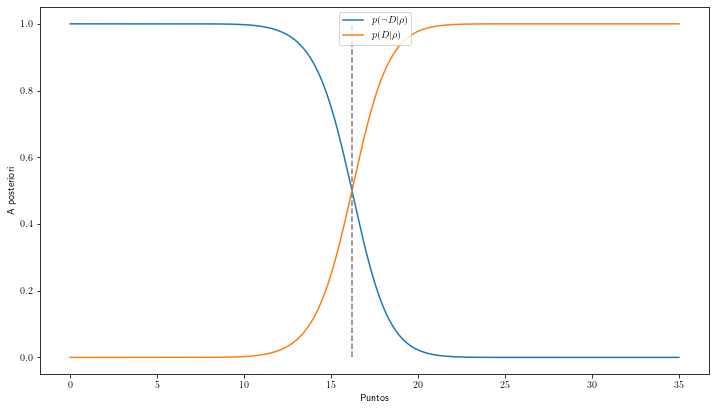

In [61]:
pnD=mgmm.posterior(0,xplot)
pD=mgmm.posterior(1,xplot)

plt.figure(figsize=figsize)
plt.rc('text', usetex=True)
plt.plot(xplot,pnD,label=r'$p(\lnot D|\rho)$')
plt.plot(xplot,pD,label=r'$p(D|\rho)$')

plt.xlabel("Puntos")
plt.ylabel("A posteriori")
plt.legend(loc='upper center')

# Cuando las dos a-posteriori son iguales, ahí será el mejor umbral de decisión
idx=np.argmin(np.abs(pnD-pD))
umbral=xplot[idx]
print("Umbral=",umbral)

plt.plot([umbral,umbral],[0,1],color="Gray",linestyle='dashed')


Para el caso de dos gaussianas, podemos despejar analíticamente el umbral de decisión, pues
se cumple

$$\ln\left(\frac{\sigma_{\lnot D}\exp\left(-\frac{1}{2}\frac{(\rho-\mu_D)^2}{\sigma_D^2}\right)}
                {\sigma_D\exp\left(-\frac{1}{2}\frac{(\rho-\mu_{\lnot D})^2}{\sigma_{\lnot D}^2}\right)}\right) 
                =
                \ln\left(\frac{p(\lnot D)}{p(D)}\right)$$
                
y reagrupando                

$$-\frac{1}{2}\left(\frac{\rho-\mu_D}{\sigma_D}\right)^2 +
  \frac{1}{2}\left(\frac{\rho-\mu_{\lnot D}}{\sigma_{\lnot D}}\right)^2
  =
  \ln\left(\frac{p(\lnot D)}{p(D)}\right)-\ln\left(\frac{\sigma_{\lnot D}}{\sigma_D}\right)$$

$$\left(\frac{\rho-\mu_{\lnot D}}{\sigma_{\lnot D}}\right)^2
  -
  \left(\frac{\rho-\mu_D}{\sigma_D}\right)^2
  =
  2\ln\left(\frac{p(\lnot D)}{p(D)}\frac{\sigma_D}{\sigma_{\lnot D}}\right)
  =
  \alpha$$
  
que tiene como soluciones

$$\rho
=
\frac{\mu_{\lnot D}\sigma_D^2-\mu_D\sigma_{\lnot D}^2
\pm
\sigma_D\sigma_{\lnot D}\sqrt{\alpha(\sigma_D^2-\sigma_{\lnot D}^2)+(\mu_D-\mu_{\lnot D})^2}}
{\sigma_D^2-\sigma_{\lnot D}^2}$$

solo una de las cuales se encontrará entre las medias de las gaussianas.

In [62]:
if best_gmm.n_components==2:
    umbral = mgmm.optimal_bayesian_threshold()
    print("Umbral bayesiano óptimo:",umbral)

Como verificación del umbral anterior, podemos encontrar el punto donde se minimiza el error.  Sin embargo, este método está discretizado a los valores que toma $t$.  Por ello, es mejor emplear el umbral $\rho$ óptimo estimado anteriormente, que debería ser muy similar a este valor.

Nótese que la intersección de los dos errores no es necesariamente el punto mínimo de error, que sí se encuentra cuando la intersección de las probabilidades _a-posteriori_ $p(\lnot D|\rho)$ y $p(D|\rho)$.

Minimal classification error of 8.91871419871788% at 16.197300000000002 pts -> 46.278000000000006%
Mean of points at 15.50925925925926 pts


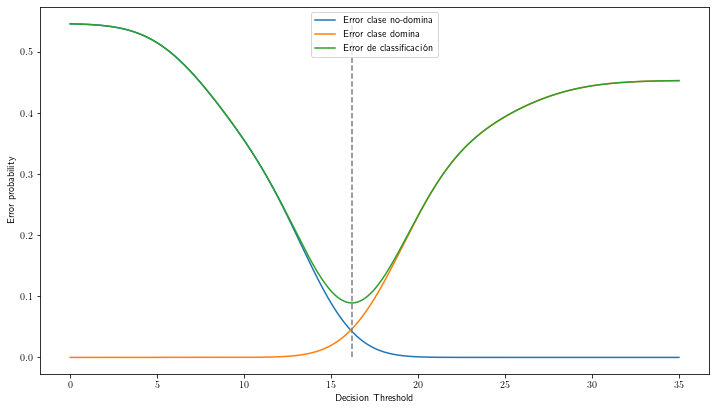

In [63]:
## Otra perspectiva: usando el error de clasificación
4
t=np.linspace(0,total_pts,total_pts*10000+1)[:,np.newaxis]

f0,f1=mgmm.errors(t)

idx = np.argmin(f0+f1)  ## Encontrar dónde se minimiza el error
threshold = t.item(int(idx))
clferror = f0.item(int(idx))+f1.item(int(idx))
print("Minimal classification error of {2}% at {0} pts -> {1}%".format(threshold,100*threshold/total_pts,100*clferror))
print("Mean of points at {0} pts".format(np.mean(pts)))

plt.figure(figsize=figsize)
plt.plot(t,f0,label="Error clase no-domina")
plt.plot(t,f1,label="Error clase domina")
plt.plot(t,f0+f1,label="Error de classificación")

plt.plot([threshold,threshold],[0,np.max(f0+f1)],color="Gray",linestyle='dashed')

plt.xlabel("Decision Threshold")
plt.ylabel("Error probability")
plt.legend(loc='upper center')

#plt.savefig("error.pdf")

# Segundo Cuartil

Otra estrategia, que se coloca aquí para comparación, es definir símplemente que una probabilidad acumulada de 50% define el puntaje (lo que equivale a la mediana de los datos).  Este método no asume un umbral óptimo de decisión, sino parte de una premisa tomada _a-priori_ de que la mitad de los estudiantes aprueban.

Podemos usar directamente los puntos, con el inconveniente de que la naturaleza fuertemente discreta del histograma y su acumulado, puede por redondeo producir un cuartil "arbitrario", por quedar la probabilidad acumulada muy cerca pero no superior al 50% buscado.  La mediana como mecanismo alternativo de cálculo da un sentido más directo a elegir el 50% de la población como aprobada.

Umbral del 1-cuartil (real): 11
Umbral del 2-cuartil (real): 15
                    Mediana: 15.0
Umbral del 3-cuartil (real): 19

Umbral del 1-cuartil (GMM): 11.277600000000001
Umbral del 2-cuartil (GMM): 15.3594
Umbral del 3-cuartil (GMM): 19.5164


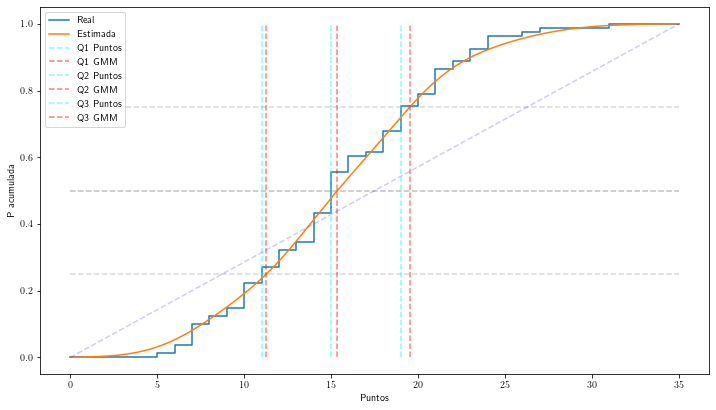

In [64]:
hist,edges=np.histogram(pts,bins=total_pts+1,range=(0,total_pts),density=False)
accpts=np.cumsum(hist)
accpd=accpts/accpts[-1]

plt.figure(figsize=figsize)

## El histograma acumulado con los datos reales
plt.step(np.arange(0,total_pts+1),accpd,label="Real",where='post') 

Q1pts=np.argmax(accpd>=0.25)
Q2pts=np.argmax(accpd>=0.5)
Q3pts=np.argmax(accpd>=0.75)

## De la estimación GMM
cumulative=mgmm.cumulative(t)
Q1gmm=t[np.argmax(cumulative>=0.25),0]
Q2gmm=t[np.argmax(cumulative>=0.5),0]
Q3gmm=t[np.argmax(cumulative>=0.75),0]
plt.plot(t,cumulative,label="Estimada")

plt.plot([0,total_pts],[0.25,0.25],color="Gray",alpha=0.3,linestyle='dashed')
plt.plot([Q1pts,Q1pts],[0,1],color="Cyan",alpha=0.5,linestyle='dashed',label="Q1 Puntos")
plt.plot([Q1gmm,Q1gmm],[0,1],color="Red",alpha=0.5,linestyle='dashed',label="Q1 GMM")

plt.plot([0,total_pts],[0.5,0.5],color="Gray",alpha=0.5,linestyle='dashed')
plt.plot([Q2pts,Q2pts],[0,1],color="Cyan",alpha=0.5,linestyle='dashed',label="Q2 Puntos")
plt.plot([Q2gmm,Q2gmm],[0,1],color="Red",alpha=0.5,linestyle='dashed',label="Q2 GMM")

plt.plot([0,total_pts],[0.75,0.75],color="Gray",alpha=0.3,linestyle='dashed')
plt.plot([Q3pts,Q3pts],[0,1],color="Cyan",alpha=0.5,linestyle='dashed',label="Q3 Puntos")
plt.plot([Q3gmm,Q3gmm],[0,1],color="Red",alpha=0.5,linestyle='dashed',label="Q3 GMM")

plt.plot([0,total_pts],[0,1],color="Blue",alpha=0.2,linestyle='dashed')

plt.xlabel("Puntos")
plt.ylabel("P acumulada")
plt.legend(loc='upper left')

print("Umbral del 1-cuartil (real):",Q1pts)
print("Umbral del 2-cuartil (real):",Q2pts)
print("                    Mediana:",np.median(pts))
print("Umbral del 3-cuartil (real):",Q3pts)

print("")

print("Umbral del 1-cuartil (GMM):",Q1gmm)
print("Umbral del 2-cuartil (GMM):",Q2gmm)
print("Umbral del 3-cuartil (GMM):",Q3gmm)


# Nota máxima

Text(0, 0.5, 'acc p(Puntos)')

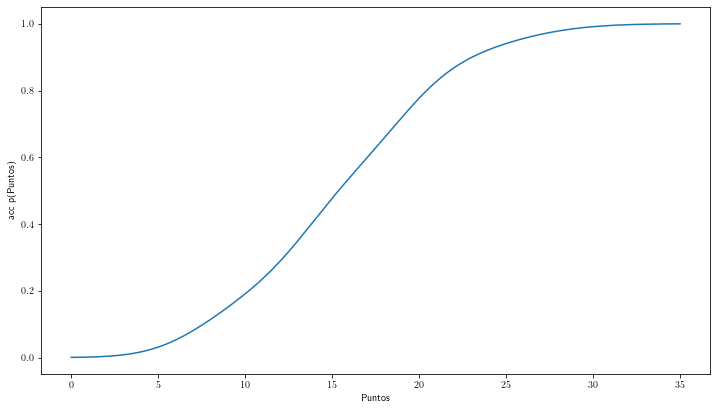

In [65]:
# De la estimación GMM, calculamos la distribución acumulada
# que indica cuál es la probabilidad de haber obtenido un número
# de puntos determinado.  Obviamente, hay un 100% de probabilidad 
# de obtener un número menor o igual al número total de puntos
# del examen.
#

## Esta es la distribución acumulada completa:
plt.figure(figsize=figsize)
plt.plot(t,cumulative)
plt.xlabel("Puntos")
plt.ylabel("acc p(Puntos)")

Puntos para 100: 29.6746


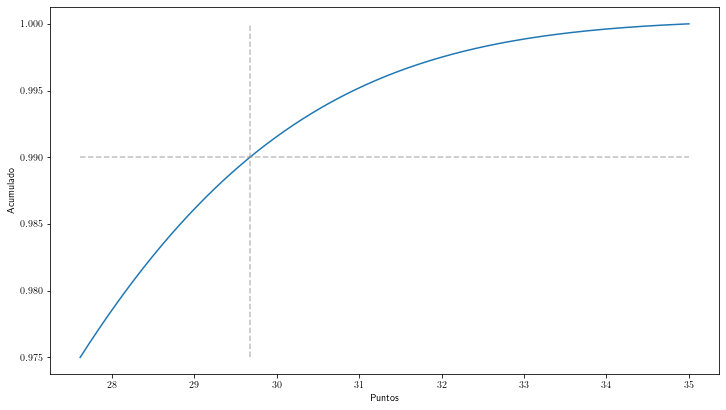

In [66]:
thres=0.975

thres100=0.99 ## Umbral de decisión para el 100 
tau=t[np.argmax(cumulative>=thres100),0]

## Mostrar solo el fragmento superior de la distribución acumulada

ids=np.where(cumulative>thres)
accpts=t[ids]
per=cumulative[ids]
plt.figure(figsize=figsize)
plt.plot(accpts,per)

plt.plot([accpts[0],accpts[-1]],[thres100,thres100],color="Gray",alpha=0.5,linestyle='dashed')
plt.plot([tau,tau],[thres,1],color="Gray",alpha=0.5,linestyle='dashed')

plt.xlabel("Puntos")
plt.ylabel("Acumulado")


print("Puntos para 100:",tau)

Puntos para abandono: 7.589700000000001  (21.684857142857144%)


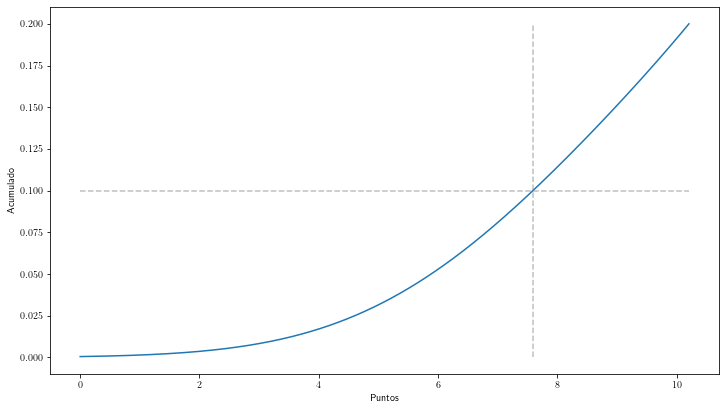

In [67]:
## ¿Quién abandonó el curso?
thres=0.2

thres10=0.1 ## Umbral de decisión para el abandono de curso
aba=t[np.argmax(cumulative>=thres10),0]

## Mostrar solo el fragmento inferior de la distribución acumulada

ids=np.where(cumulative<thres)
accpts=t[ids]
per=cumulative[ids]
plt.figure(figsize=figsize)
plt.plot(accpts,per)

plt.plot([accpts[0],accpts[-1]],[thres10,thres10],color="Gray",alpha=0.5,linestyle='dashed')
plt.plot([aba,aba],[0,thres],color="Gray",alpha=0.5,linestyle='dashed')

plt.xlabel("Puntos")
plt.ylabel("Acumulado")


print("Puntos para abandono: {0}  ({1}%)".format(aba,100*aba/total_pts))

# Promediando umbrales de múltiples corridas

Hay varios factores aleatorios aun después de la selección del ancho de banda
que afectan el posicionamiento de las gaussianas finales, lo que afecta los umbrales estimados.

Queremos revisar aquí qué tan dependientes serán estos umbrales respecto al ancho de banda seleccionado.

Ejecutaremos a continuación lo realizado en los pasos anteriores múltiples veces 
para obtener finalmente umbrales ligeramente más estables.

In [68]:
if detailed_stats:
    bws=list(np.linspace(bw_-0.5,bw_+0.5,11))
else:
    bws=list()
    
bws.append(bw_) # Asegure que el BW óptimo está en la lista
bws=np.sort(np.unique(bws))

idxbw_ = np.where(bws==bw_)

# Cambiar force si es requerido recalcular esto por alguna situación
ths,toc=m.thresholdStats(pts=pts,
                         total_pts=total_pts,
                         bws=bws,
                         n_components_range=n_components_range,
                         reps=400,
                         thres10=thres10,
                         thres100=thres100,
                         load_file="thresh.pik",
                         force=False)

print("\n\nTardó {0}".format(time.strftime('%Hh %Mm %Ss',time.gmtime(toc))))

# Recuperemos los anchos de banda realmente presentes en ths
bws=np.unique(ths[:,4])
if bws[idxbw_]!=bw_:
    print("BW almacenado {0} y estimado ahora {1}",bws[idxbw_],bw_)
    bw_=bws[idxbw_]

th10,th70,th100,_,_=np.mean(ths,axis=0)

print("Mean:",[th10,th70,th100])
      
std10,std70,std100,_,_=np.std(ths,axis=0)
print("StDev:",[std10,std70,std100])

# Revisemos por curiosidad cuántas gaussianas se usaron en general
print("\nCuántas gaussianas se usaron durante los experimentos:\n")
numG,counts=np.unique(ths[:,3],return_counts=True)
for n,c in zip(numG,counts):
    print("{0} gaussianas {1:.2f}% de las veces".format(int(n),100*c/np.sum(counts)))

File 'thresh.pik': [Errno 2] No such file or directory: 'thresh.pik'
400/400 [ 7.6427     16.3415     29.7211      4.          2.63321963]                   
Saving file 'thresh.pik'


Tardó 00h 07m 06s
Mean: [7.674254249999999, 16.259162500000013, 29.840071749999993]
StDev: [0.080129879145906, 0.3448319715365006, 0.2424219313035384]

Cuántas gaussianas se usaron durante los experimentos:

2 gaussianas 1.00% de las veces
4 gaussianas 57.75% de las veces
6 gaussianas 35.00% de las veces
8 gaussianas 6.25% de las veces


In [69]:
split_ths70=[ths[ths[:,4]==k,1] for k in bws]
label_bws=["BW {:.3f}".format(k) for k in bws]

Text(0, 0.5, 'Umbral 70')

<Figure size 864x486 with 0 Axes>

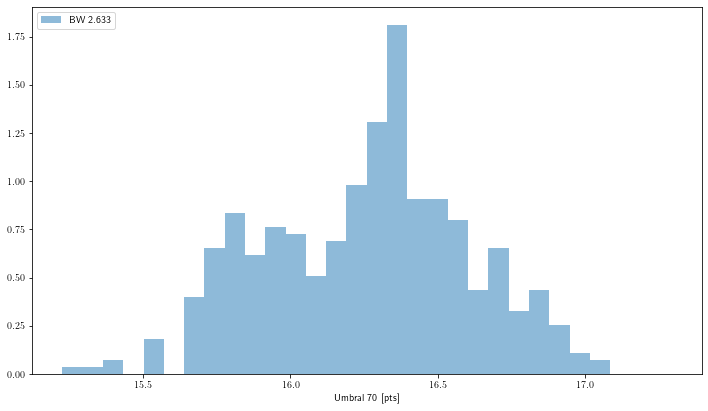

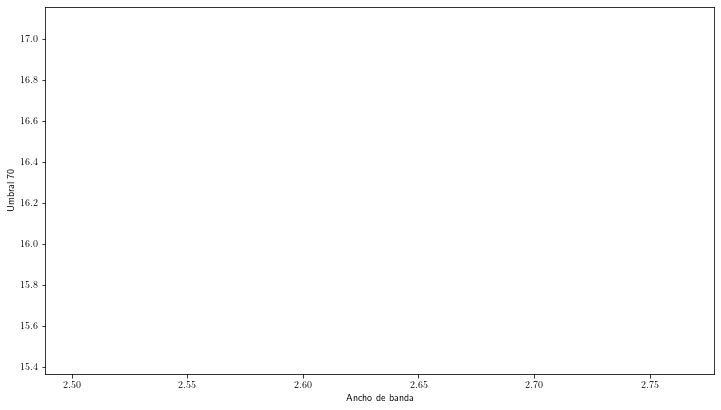

In [70]:
plt.figure(figsize=figsize)
figh70, axh70 = plt.subplots(figsize=figsize)
range_th70=(th70-3*std70,th70+3*std70)

_ = plt.hist(split_ths70,
             bins=30,
             range=range_th70,
             density=True,
             alpha=0.5,
             histtype='barstacked',
             label=label_bws)
plt.legend(loc='upper left')
plt.xlabel("Umbral 70 [pts]")
plt.ylabel("% de experimentos que seleccionó umbral")

meanthpbw=list(map(np.mean,split_ths70))
plt.figure(figsize=figsize)
plt.plot(bws,meanthpbw)
plt.plot([bw_,bw_],[np.min(meanthpbw),np.max(meanthpbw)],color="Red")
plt.xlabel("Ancho de banda")
plt.ylabel("Umbral 70")

Text(0, 0.5, 'Umbral 10')

<Figure size 864x486 with 0 Axes>

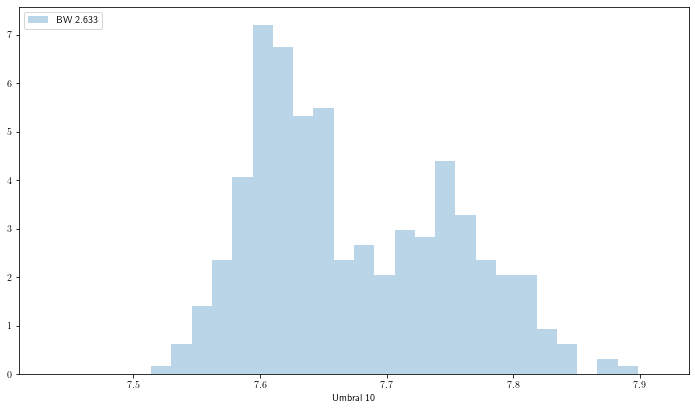

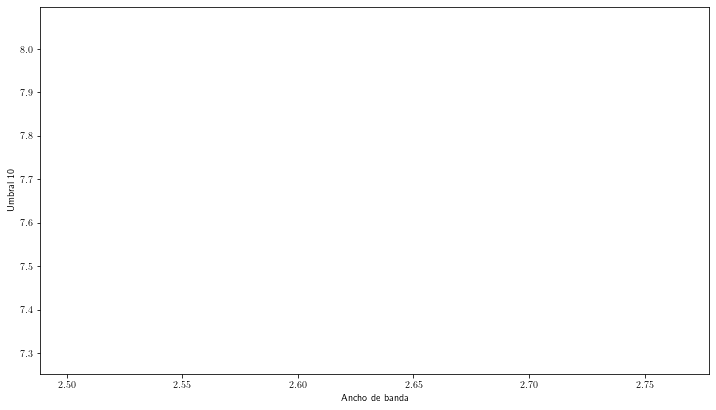

In [71]:
split_ths10=[ths[ths[:,4]==k,0] for k in bws]

plt.figure(figsize=figsize)
figh10, axh10 = plt.subplots(figsize=figsize)
range_th10=(th10-3*std10,th10+3*std10)

_ = plt.hist(split_ths10,
             bins=30,
             range=range_th10,
             density=True,
             alpha=0.3,
             histtype='barstacked',
             label=label_bws)
plt.legend(loc='upper left')
plt.xlabel("Umbral 10")
plt.ylabel("% de experimentos que seleccionó umbral")

meanth10pbw=list(map(np.mean,split_ths10))
plt.figure(figsize=figsize)
plt.plot(bws,meanth10pbw)
plt.plot([bw_,bw_],[np.min(meanth10pbw),np.max(meanth10pbw)],color="Red")
plt.xlabel("Ancho de banda")
plt.ylabel("Umbral 10")


Text(0, 0.5, 'Umbral 100')

<Figure size 864x486 with 0 Axes>

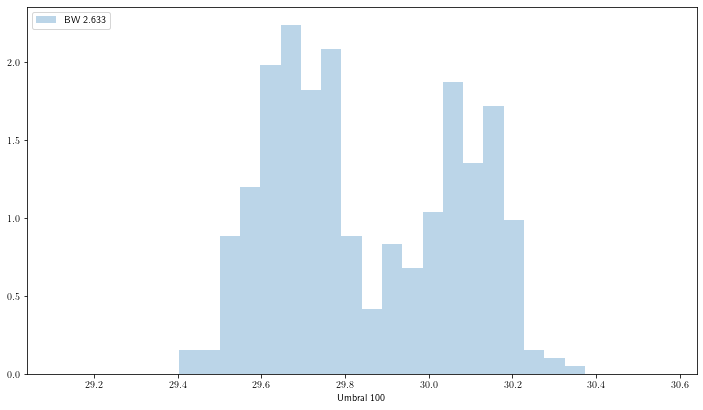

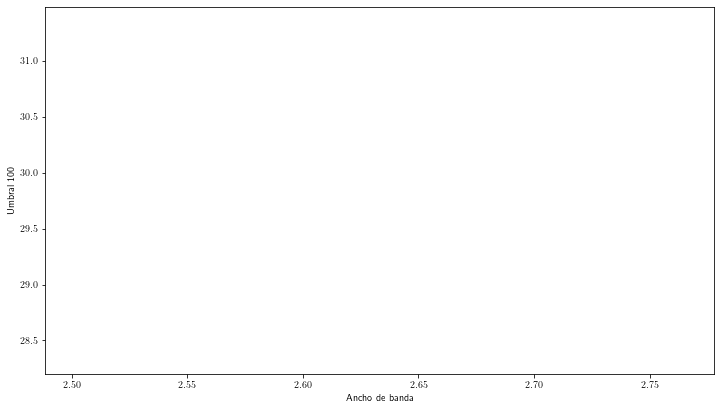

In [72]:
split_ths100=[ths[ths[:,4]==k,2] for k in bws]

plt.figure(figsize=figsize)
figh100, axh100 = plt.subplots(figsize=figsize)
range_th100=(th100-3*std100,th100+3*std100)

_ = plt.hist(split_ths100,
             bins=30,
             range=range_th100,
             density=True,
             alpha=0.3,
             histtype='barstacked',
             label=label_bws)
plt.legend(loc='upper left')
plt.xlabel("Umbral 100")
plt.ylabel("% de experimentos que seleccionó umbral")

meanth100pbw=list(map(np.mean,split_ths100))
plt.figure(figsize=figsize)
plt.plot(bws,meanth100pbw)
plt.plot([bw_,bw_],[np.min(meanth100pbw),np.max(meanth100pbw)],color="Red")
plt.xlabel("Ancho de banda")
plt.ylabel("Umbral 100")


### Selección definitiva de los umbrales

Si hicimos el análisis bien, ya tendremos el análisis del mejor ancho de banda arriba
dentro de las estadísticas.  Sino, tendremos que hacerlo.

In [73]:
idx,closestbw=min(enumerate(bws), key=lambda x: abs(x[1]-bw_))

if (abs(closestbw-bw_)<1.0e-6):
    # Ya tenemos las estadísticas

    print("Reutilizando datos ya calculados para los anchos de banda")
    
    samples10=split_ths10[idx].copy().reshape(-1,1)
    samples70=split_ths70[idx].copy().reshape(-1,1)
    samples100=split_ths100[idx].copy().reshape(-1,1)

    th10=np.mean(samples10)
    th70=np.mean(samples70)
    th100=np.mean(samples100)
    
    std10=np.std(samples10)
    std70=np.std(samples70)
    std100=np.std(samples100)

    
else:
    print("Anchos de banda analizados no incluyen al óptimo.  Recalculando.")

    ths,toc=m.thresholdStats(pts=pts,
                             total_pts=total_pts,
                             bws=[bw_],
                             n_components_range=n_components_range,
                             reps=400,
                             thres10=thres10,
                             thres100=thres100,
                             load_file="thresh_final.pik",
                             force=False)

    print("\n\nTardó {0}".format(time.strftime('%Hh %Mm %Ss',time.gmtime(toc))))

    samples10=ths[:,0].copy().reshape(-1,1)
    samples70=ths[:,1].copy().reshape(-1,1)
    samples100=ths[:,2].copy().reshape(-1,1)
    
    th10,th70,th100,_,_=np.mean(ths,axis=0)
    std10,std70,std100,_,_=np.std(ths,axis=0)

Reutilizando datos ya calculados para los anchos de banda


In [74]:
# Calculando un GMM para los umbrales de 70

gmm70=m.fitGMM(samples=samples70,n_components_range=range(1,6),quiet=False)
idx70=np.argmax(gmm70.weights_)
th70=gmm70.means_[idx70,0]
std70=np.sqrt(gmm70.covariances_[idx70])

  bic con 1 componentes = 295.3753399780837
  bic con 2 componentes = 301.43897998456447
  bic con 3 componentes = 302.3274044623472
  bic con 4 componentes = 320.8891845348357
  bic con 5 componentes = 330.3300630795448
Best components: 1


In [75]:
gmm70.means_[0]

array([16.2591625])

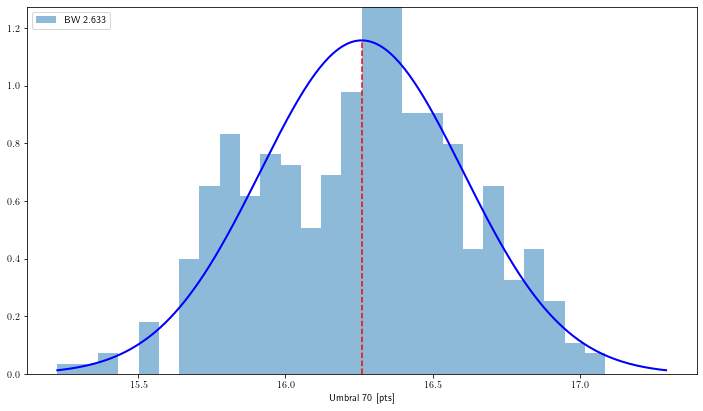

<Figure size 864x486 with 0 Axes>

In [76]:
# Sobrepongamos a los histogramas de umbral-70 por bandwidth, la selección final
plt.figure(figsize=figsize)

xr70=np.linspace(range_th70[0],range_th70[1],250)
# gauss=norm(th70,std70).pdf(xr70)

# Muestre las gaussianas estimadas
for i in np.arange(len(gmm70.weights_)):
    axh70.plot(xr70,
               gmm70.weights_[i]*
               norm(gmm70.means_[i],np.sqrt(gmm70.covariances_[i])).pdf(xr70),
               color="Gray",alpha=0.5) 

gauss=gmm70.weights_[idx70]*norm(th70,std70).pdf(xr70)   
axh70.plot(xr70,gauss,linewidth=2,color="Blue")
axh70.plot([th70,th70],[0,1/(np.sqrt(2*np.pi)*std70)],color="Red",linestyle='dashed')
axh70.set_ylim([0,np.max(gauss)*1.1])

figh70


In [77]:
gmm10=m.fitGMM(samples=samples10,n_components_range=range(1,6),quiet=False)
idx10=np.argmax(gmm10.weights_)
th10=gmm10.means_[idx10,0]
std10=np.sqrt(gmm10.covariances_[idx10])

  bic con 1 componentes = -872.1514166269029
  bic con 2 componentes = -952.785639785748
  bic con 3 componentes = -932.1431129217796
  bic con 4 componentes = -917.8182346633032
  bic con 5 componentes = -899.7476904768899
Best components: 2


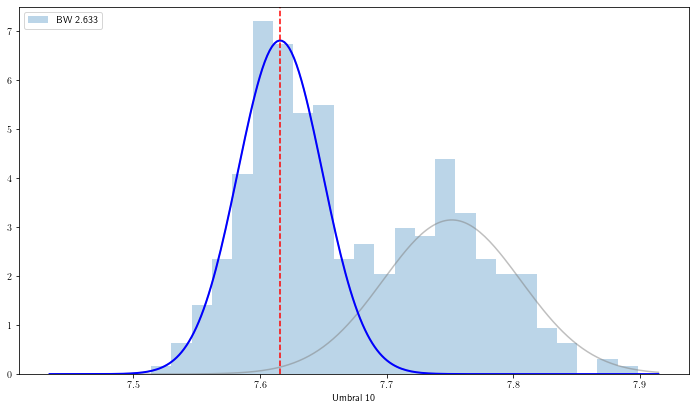

<Figure size 864x486 with 0 Axes>

In [78]:
# Sobrepongamos a los histogramas de umbral-100 por bandwidth, la selección final
plt.figure(figsize=figsize)

xr10=np.linspace(range_th10[0],range_th10[1],250)

# Muestre las gaussianas estimadas
for i in np.arange(len(gmm10.weights_)):
    axh10.plot(xr10,
               gmm10.weights_[i]*
               norm(gmm10.means_[i],np.sqrt(gmm10.covariances_[i])).pdf(xr10),
               color="Gray",alpha=0.5) 
    
gauss=gmm10.weights_[idx10]*norm(th10,std10).pdf(xr10)

axh10.plot(xr10,gauss,linewidth=2,color="Blue")
axh10.plot([th10,th10],[0,1/(np.sqrt(2*np.pi)*std10)],color="Red",linestyle='dashed')
axh10.set_ylim([0,np.max(gauss)*1.1])

figh10

In [79]:
gmm100=m.fitGMM(samples=samples100,n_components_range=range(1,6),quiet=False)
idx100=np.argmax(gmm100.weights_)
th100=gmm100.means_[idx100,0]
std100=np.sqrt(gmm100.covariances_[idx100])

  bic con 1 componentes = 13.473313152241182
  bic con 2 componentes = -44.65780736021158
  bic con 3 componentes = -149.33181397877655
  bic con 4 componentes = -130.55585286411846
  bic con 5 componentes = -115.10862666522884
Best components: 3


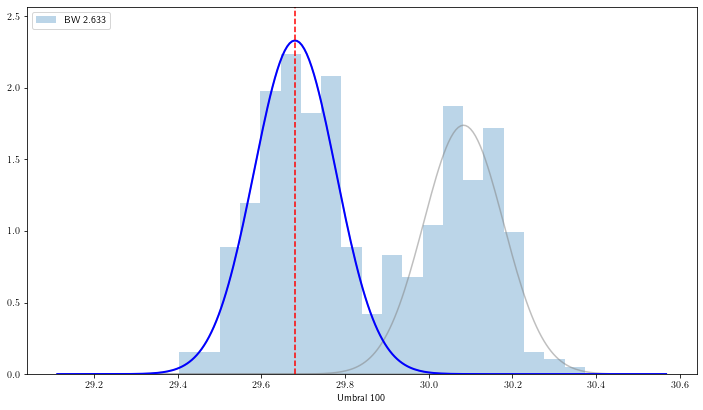

<Figure size 864x486 with 0 Axes>

In [80]:
## Estadísticas del examen final# Sobrepongamos a los histogramas de umbral-100 por bandwidth, la selección final
plt.figure(figsize=figsize)

xr100=np.linspace(range_th100[0],range_th100[1],250)

# Muestre las gaussianas estimadas
for i in np.arange(len(gmm100.weights_)):
    axh100.plot(xr100,
               gmm100.weights_[i]*
               norm(gmm100.means_[i],np.sqrt(gmm100.covariances_[i])).pdf(xr100),
               color="Gray",alpha=0.5) 



gauss=gmm100.weights_[idx100]*norm(th100,std100).pdf(xr100)

axh100.plot(xr100,gauss,linewidth=2,color="Blue")
axh100.plot([th100,th100],[0,1/(np.sqrt(2*np.pi)*std100)],color="Red",linestyle='dashed')
axh100.set_ylim([0,np.max(gauss)*1.1])

figh100

# Resumen

Finalmente la curva de notas es la siguiente:

In [81]:
print("Umbral de puntos para AC:  {0:.3f} ({1:.2f}%)".format(th10,th10*100/total_pts))
print("Umbral de puntos para 70:  {0:.3f} ({1:.2f}%)".format(th70,th70*100/total_pts))
print("Umbral de puntos para 100: {0:.3f} ({1:.2f}%)".format(th100,th100*100/total_pts))

Umbral de puntos para AC:  7.616 (21.76%)
Umbral de puntos para 70:  16.259 (46.45%)
Umbral de puntos para 100: 29.681 (84.80%)


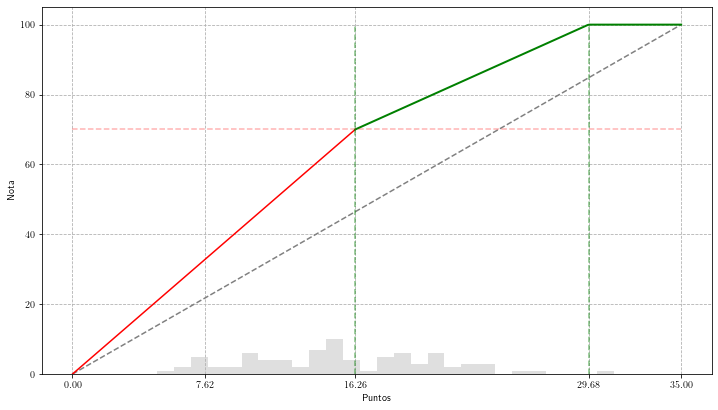

In [82]:
umbral=th70
xnd=np.linspace(0,umbral,10)
xd=np.linspace(umbral,total_pts,200)

m_nd=70/umbral
b_nd=0
m_d=(100-70)/(tau-umbral)
b_d=70-m_d*umbral

plt.figure(figsize=figsize)

plt.hist(pts,bins=total_pts+1,range=(0,total_pts),density=False,color="Gray",alpha=0.25)

plt.plot([0,total_pts],[0,100],color="Gray",linestyle='dashed')
plt.plot(xnd,xnd*m_nd+b_nd,color="Red")
plt.plot(xd,np.minimum(100,xd*m_d+b_d),color="Green",linewidth=2)

plt.plot([0,total_pts],[70,70],color="Red",alpha=0.3,linestyle='dashed')
plt.plot([th70,th70],[0,100],color="Green",alpha=0.5,linestyle='dashed')
plt.plot([th100,th100],[0,100],color="Green",alpha=0.5,linestyle='dashed')

plt.grid(True,which='both',linestyle='dashed')

plt.xlabel("Puntos")
plt.ylabel("Nota")
_=plt.xticks(list([0,th10,th70,th100,total_pts]))